<span style="font-family:Helvetica Light">
    
# The Bar Chart Race - Top Artist and Top Song Race

## The goal of this notebook:
The goal of this notebook is to:
* visualize with a racing bar chart which artists through out the year ended up as my Top Artists of 2021
* visualize with a racing bar chart which artists through out the year ended up as my Top Songs of 2021

## About Bar Chart Race library

Bar Chart Race is one of the libraries from under the Dexplo hood.
From the <a href="https://www.dexplo.org/bar_chart_race/" target="_blank">official documentation</a> of the library:

<blockquote>
The overall aim of the dexplo suite of libraries is supply a powerful and efficient set of tools for doing data analysis and visualization in Python. [...] Make animated bar chart races in Python with matplotlib.
</blockquote>

#### References:
1. https://www.dexplo.org/bar_chart_race/tutorial/

</span>

<span style="font-family:Helvetica Light">
    
# 1. Set-up & Data Loading
    
Loading neccessary libraries.
    
Loading the streaming history file prepared in the previous step.
    
</span>

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import bar_chart_race as bcr

In [2]:
df = pd.read_csv('spotify_my_streaming_history_2021_enriched_w_pod.csv',index_col=0)
df.head(3)

,endTime,artistName,trackName,msPlayed,hour,date,week,month,sPlayed,mPlayed,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artistGenres,podcastName,podcastId,imageUrl
0,2021-01-01 06:01:00,Julia Wieniawa,Niezadowolona (piosenka do filmu „Wszyscy moi ...,44827,6,2021-01-01,2020-12-28,2021-01-01,44.827,0.747117,...,0.013800,0.204,0.367,114.018,229474.0,4.0,"['polish alternative', 'polish pop']",NaN,NaN,NaN
1,2021-01-01 06:01:00,Ariana Grande,god is a woman - live,31750,6,2021-01-01,2020-12-28,2021-01-01,31.750,0.529167,...,0.000007,0.971,0.279,144.882,213068.0,4.0,"['dance pop', 'pop']",NaN,NaN,NaN
2,2021-01-01 06:04:00,Justin Bieber,Anyone,190779,6,2021-01-01,2020-12-28,2021-01-01,190.779,3.179650,...,0.000003,0.113,0.584,115.884,190779.0,4.0,"['canadian pop', 'pop']",NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45085 entries, 0 to 45084
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   endTime           45085 non-null  object 
 1   artistName        45085 non-null  object 
 2   trackName         45085 non-null  object 
 3   msPlayed          45085 non-null  int64  
 4   hour              45085 non-null  int64  
 5   date              45085 non-null  object 
 6   week              45085 non-null  object 
 7   month             45085 non-null  object 
 8   sPlayed           45085 non-null  float64
 9   mPlayed           45085 non-null  float64
 10  hPlayed           45085 non-null  float64
 11  trackId           43178 non-null  object 
 12  popularity        43178 non-null  float64
 13  artistId          43178 non-null  object 
 14  danceability      43178 non-null  float64
 15  energy            43178 non-null  float64
 16  key               43178 non-null  float6

In [4]:
df.endTime = pd.to_datetime(df.endTime) 
df.date = pd.to_datetime(df.date) 
df.week = pd.to_datetime(df.week) 
df.month = pd.to_datetime(df.month) 
df.head(2)

,endTime,artistName,trackName,msPlayed,hour,date,week,month,sPlayed,mPlayed,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artistGenres,podcastName,podcastId,imageUrl
0,2021-01-01 06:01:00,Julia Wieniawa,Niezadowolona (piosenka do filmu „Wszyscy moi ...,44827,6,2021-01-01,2020-12-28,2021-01-01,44.827,0.747117,...,0.013800,0.204,0.367,114.018,229474.0,4.0,"['polish alternative', 'polish pop']",NaN,NaN,NaN
1,2021-01-01 06:01:00,Ariana Grande,god is a woman - live,31750,6,2021-01-01,2020-12-28,2021-01-01,31.750,0.529167,...,0.000007,0.971,0.279,144.882,213068.0,4.0,"['dance pop', 'pop']",NaN,NaN,NaN


In [5]:
# double checking for duplicates
df.duplicated(subset=['endTime','artistName','trackName','msPlayed']).sum()

0

In [6]:
# remove duplicates
df.drop_duplicates(inplace=True)

# double checking for duplicates
df.duplicated().sum()

0

<span style="font-family:Helvetica Light">
    
# 2. Data Prep
    
From the <a href="https://www.dexplo.org/bar_chart_race/tutorial/" target="_blank">official guide</a> of the library:
<blockquote>    
The data you choose to animate as a bar chart race must be provided in a specific format. The data must be within a pandas DataFrame containing 'wide' data where:

* Each row represents a single period of time
* Each column holds the value for a particular category
* The index contains the time component (optional)
</blockquote>
    
The Top Artists and Top Songs are based on the playcount. 

For the purpose of this analysis I excluded all the records with time played under 10 seconds assuming those were just 'skip to the next one' cases.

    
## 2.1. Top Artsits Bar Chart Race    
</span>

In [7]:
# based on playcount
# plays for less than 10 seconds are assumed song skips (for clearer results)

df_no_skips = df.loc[df['sPlayed']>10]

weekly_artist = df_no_skips.groupby([pd.Grouper(key='endTime', freq='W'),'artistName'])['trackName'].size().reset_index()
weekly_artist['no_csum'] = weekly_artist.groupby(['artistName'])['trackName'].cumsum()

#choosing only top5 artist in a given week
weekly_artist_top_10 = weekly_artist.set_index(['endTime', 'artistName']).groupby(level=0, group_keys=False)['no_csum'].nlargest(5)

#reformatting the data into format suitable for the bar_chart_race package
weekly_artist_top_10 = weekly_artist_top_10.unstack()
weekly_artist_top_10.fillna(method='ffill', inplace=True)
weekly_artist_top_10.fillna(0, inplace=True)


In [8]:
def initiate_chart(title):
    
    plt.rcParams['font.family'] = 'Helvetica'
    
    #initiate fig
    fig, ax = plt.subplots(figsize=(12,8), facecolor='white', dpi= 80)

    ax.margins(0, 0.01)
    ax.set_axisbelow(True)

    #ticks
    ax.grid(which='major', axis='x', linestyle='-', linewidth=0.2, color='dimgrey')
    ax.tick_params(axis='x', colors='dimgrey', labelsize=12, length=0)
    ax.tick_params(axis='y', colors='dimgrey', labelsize=12, length=0)

    for pos in ['top', 'bottom', 'right', 'left']:
            if pos == 'top':
                ax.spines[pos].set_edgecolor('dimgrey')
            else:
                ax.spines[pos].set_edgecolor('white')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    
    ax.set_title(title, fontsize=18, color='dimgrey')
    
    return fig, ax

CPU times: user 1min 15s, sys: 3.81 s, total: 1min 19s
Wall time: 1min 41s


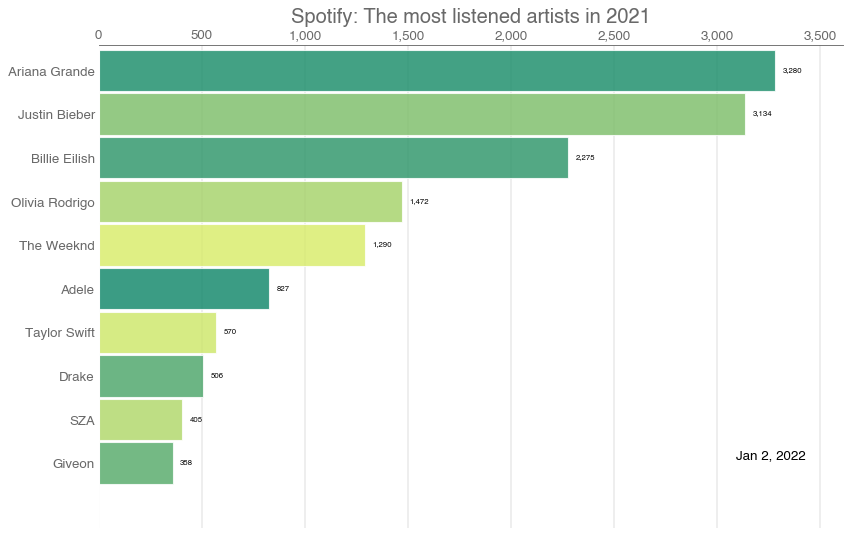

In [13]:
%%time
# help(bcr.bar_chart_race)

palette = sns.color_palette("summer", 24).as_hex()
title = 'Spotify: The most listened artists in 2021'

#initiate chart
fig, ax = initiate_chart(title)

bcr.bar_chart_race(df=weekly_artist_top_10, 
                   n_bars=10, 
                   fig=fig, 
                   period_length=400, 
                   cmap=palette, 
                   period_fmt='%b %-d, %Y',
                   filter_column_colors=True,
                   filename='medium__artists.mp4')

<span style="font-family:Helvetica Light">
    
## 2.2. Top Songs Bar Chart Race 

</span>

In [10]:
# based on playcount
# plays for less than 10 seconds are assumed song skips (for clearer results)

df_no_skips = df_no_skips.copy()
df_no_skips['artistTrackName'] = df['artistName']+' - '+df['trackName']

weekly_song = df_no_skips.groupby([pd.Grouper(key='endTime', freq='W'),'artistTrackName'])['trackId'].size().reset_index()
weekly_song['no_csum'] = weekly_song.groupby(['artistTrackName'])['trackId'].cumsum()

# shortening the track name for clearer representation on the chart
weekly_song['artistTrackName'] = weekly_song['artistTrackName'].str.split('(').str[0]
weekly_song['artistTrackName'] = [label.replace(' - ', ': \n') for label in weekly_song['artistTrackName']]

#choosing only top5 artist in a given week
weekly_song_top_10 = weekly_song.set_index(['endTime', 'artistTrackName']).groupby(level=0, group_keys=False)['no_csum'].nlargest(5)

#reformatting the data into format suitable for the bar_chart_race package
weekly_song_top_10 = weekly_song_top_10.unstack()
weekly_song_top_10.fillna(method='ffill', inplace=True)
weekly_song_top_10.fillna(0, inplace=True)


CPU times: user 1min 16s, sys: 4.18 s, total: 1min 21s
Wall time: 1min 39s


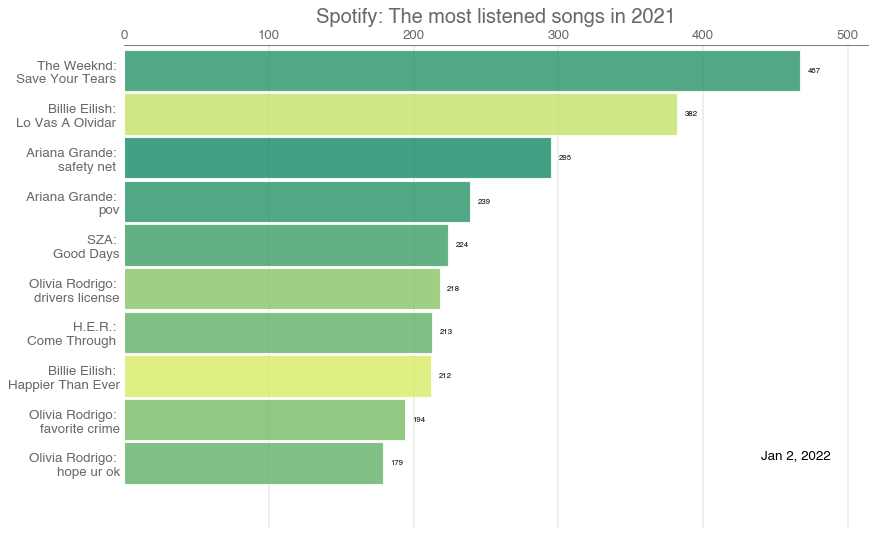

In [12]:
%%time
# help(bcr.bar_chart_race)

palette = sns.color_palette("summer_r", 12).as_hex()
title = 'Spotify: The most listened songs in 2021'

#initiate chart
fig, ax = initiate_chart(title)

bcr.bar_chart_race(df=weekly_song_top_10, 
                   n_bars=10, 
                   fig=fig, 
                   period_length=400, 
                   cmap=palette, 
                   period_fmt='%b %-d, %Y',
                   filter_column_colors=True,
                   filename='medium__songs.mp4')